Upper-tail percentile thresholds (P(count >= t) = p%):
P25: t = 4,967
P50: t = 127
P75: t = 11
P95: t = 2
P99: t = 1


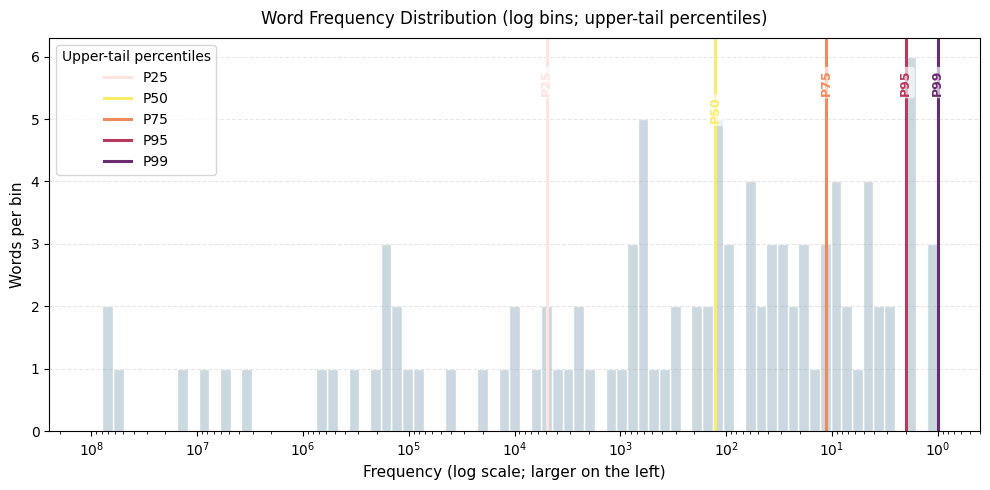

In [ ]:
# -*- coding: utf-8 -*-
# Long-tail histogram of word frequencies with LOG-spaced bins.
# Fix: removed access to non-public legendHandles to avoid AttributeError.
# Percentile lines use UPPER-TAIL definition: P(count >= t) = p% (so P99 is near small counts on the right).

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ---------- Config ----------
csv_path = "/Users/zhzhou/Desktop/SafeContextualReward/results/word_synthesis/v4_rpj_llama_s4/union_all_words_wf50000.csv"
n_bins   = 80
figsize  = (10, 5)

# Bar aesthetics (non-default)
bar_color = "#C9D6DF"   # softened cool gray-blue
alpha_bar = 0.95
edgecolor = "#FFFFFF"

line_width = 2.2
tail_percents = [25, 50, 75, 95, 99]  # upper-tail levels
line_colors = {
    25: "#FFE3E1",
    50: "#F9ED69",
    75: "#F08A5D",
    95: "#B83B5E",
    99: "#6A2C70",
}

save_path = None  # e.g., "/tmp/long_tail_hist.png"
dpi = 180
# ----------------------------

assert os.path.exists(csv_path), f"CSV not found: {csv_path}"

# Read only the 'count' column
df = pd.read_csv(csv_path, usecols=["count"], dtype={"count": "int64"})
counts = df["count"].to_numpy()
counts = counts[counts > 0]
if counts.size == 0:
    raise ValueError("No positive counts to plot.")

# Upper-tail percentile thresholds: find t s.t. P(count >= t) = p%
pct_query = [100 - p for p in tail_percents]  # convert to ascending-space percentiles
tail_thresh = np.percentile(counts, pct_query)

# Log-spaced bins across [min, max]
min_c = max(int(counts.min()), 1)
max_c = int(counts.max())
bins = np.logspace(np.floor(np.log10(min_c)), np.ceil(np.log10(max_c)), num=n_bins)

# Plot
fig, ax = plt.subplots(figsize=figsize)
ax.hist(
    counts,
    bins=bins,
    histtype="bar",
    color=bar_color,
    alpha=alpha_bar,
    edgecolor=edgecolor,
)

# X axis: log scale, larger on the left
ax.set_xscale("log")
ax.invert_xaxis()

# X ticks as descending powers of 10
exp_min = int(np.floor(np.log10(min_c)))
exp_max = int(np.ceil(np.log10(max_c)))
xticks = (10.0 ** np.arange(exp_max, exp_min - 1, -1)).astype(float)
ax.set_xticks(xticks)
ax.get_xaxis().set_major_formatter(mticker.LogFormatterMathtext(base=10))

# Y ticks with thousands separators
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{int(y):,}"))

# Grid for readability
ax.grid(axis="y", linestyle="--", alpha=0.3)

# Labels & title (EN)
ax.set_xlabel("Frequency (log scale; larger on the left)", fontsize=11)
ax.set_ylabel("Words per bin", fontsize=11)
ax.set_title("Word Frequency Distribution (log bins; upper-tail percentiles)", fontsize=12, pad=10)

# Vertical upper-tail percentile lines + labels
y_top = ax.get_ylim()[1]
for p, t in zip(tail_percents, tail_thresh):
    color = line_colors[p]
    ax.axvline(t, color=color, linestyle="-", linewidth=line_width, alpha=1.0, label=f"P{p}")
    ax.text(
        t,
        y_top * (0.92 if p % 2 else 0.85),
        f"P{p}",
        rotation=90,
        va="top",
        ha="center",
        color=color,
        fontsize=9,
        fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.65),
    )

# Legend (no post-hoc handle styling to avoid AttributeError)
ax.legend(frameon=True, loc="upper left", title="Upper-tail percentiles")

plt.tight_layout()
if save_path:
    plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
# plt.show()

# Optional: print thresholds for logging
print("Upper-tail percentile thresholds (P(count >= t) = p%):")
for p, t in zip(tail_percents, tail_thresh):
    print(f"P{p}: t = {int(t):,}")


Upper-tail percentile thresholds (P(count >= t) = p%):
P25: t = 4,420,907
P50: t = 977,915
P75: t = 209,255
P95: t = 6,356
P99: t = 2,223


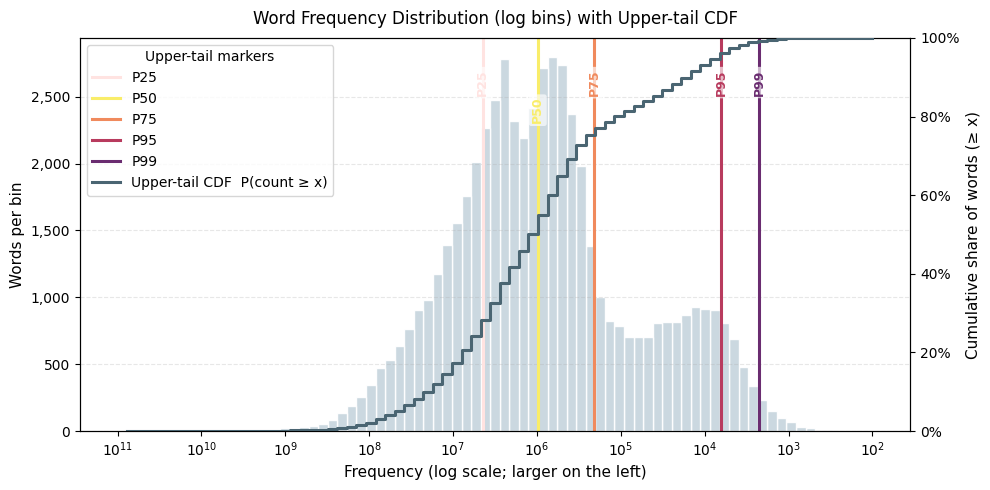

In [3]:
# -*- coding: utf-8 -*-
# Histogram (log-binned, left=large -> right=small) + UPPER-TAIL CDF overlay.
# Percentile lines are defined as P(count >= t) = p% (so P99 is near the small-count region).

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ---------- Config ----------
csv_path = "/Users/zhzhou/Desktop/SafeContextualReward/results/word_synthesis/v4_rpj_llama_s4/union_all_words_wf50000.csv"
n_bins   = 80
figsize  = (10, 5)

# Bar aesthetics (non-default)
bar_color  = "#C9D6DF"   # softened cool gray-blue
alpha_bar  = 0.95
edgecolor  = "#FFFFFF"

# CDF line aesthetics
cdf_color  = "#4A6572"
cdf_width  = 2.2

# Percentile lines (upper tail)
tail_percents = [25, 50, 75, 95, 99]
line_colors = {
    25: "#FFE3E1",
    50: "#F9ED69",
    75: "#F08A5D",
    95: "#B83B5E",
    99: "#6A2C70",
}
line_width = 2.2

save_path = None  # e.g., "/tmp/long_tail_hist_with_cdf.png"
dpi = 180
# ----------------------------

assert os.path.exists(csv_path), f"CSV not found: {csv_path}"

# Read only the 'count' column
df = pd.read_csv(csv_path, usecols=["count"], dtype={"count": "int64"})
counts = df["count"].to_numpy()
counts = counts[counts > 0]
if counts.size == 0:
    raise ValueError("No positive counts to plot.")

# Upper-tail percentile thresholds: find t s.t. P(count >= t) = p%
pct_query   = [100 - p for p in tail_percents]   # convert to ascending-space percentiles
tail_thresh = np.percentile(counts, pct_query)

# Log-spaced bins across [min, max]
min_c = max(int(counts.min()), 1)
max_c = int(counts.max())
bins  = np.logspace(np.floor(np.log10(min_c)), np.ceil(np.log10(max_c)), num=n_bins)

# --- Figure & primary axis (hist) ---
fig, ax = plt.subplots(figsize=figsize)

# Histogram: Y = number of words in each bin
hist_vals, _, _ = ax.hist(
    counts,
    bins=bins,
    histtype="bar",
    color=bar_color,
    alpha=alpha_bar,
    edgecolor=edgecolor,
    zorder=1,
)

# X axis: log scale, larger on the LEFT
ax.set_xscale("log")
ax.invert_xaxis()

# X ticks as descending powers of 10
exp_min = int(np.floor(np.log10(min_c)))
exp_max = int(np.ceil(np.log10(max_c)))
xticks  = (10.0 ** np.arange(exp_max, exp_min - 1, -1)).astype(float)
ax.set_xticks(xticks)
ax.get_xaxis().set_major_formatter(mticker.LogFormatterMathtext(base=10))

# Y ticks (hist) with thousands separators
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{int(y):,}"))

# Grid for readability
ax.grid(axis="y", linestyle="--", alpha=0.3)

# Labels & title (EN)
ax.set_xlabel("Frequency (log scale; larger on the left)", fontsize=11)
ax.set_ylabel("Words per bin", fontsize=11)
ax.set_title("Word Frequency Distribution (log bins) with Upper-tail CDF", fontsize=12, pad=10)

# --- Secondary axis for CDF (upper-tail) ---
ax2 = ax.twinx()

# Compute upper-tail CDF on the same bins:
# hist_vals correspond to counts in ascending bins; CCDF[i] = sum(hist_vals[i:]) / total
total_words = hist_vals.sum()
ccdf = np.cumsum(hist_vals[::-1])[::-1] / max(total_words, 1)

# Plot at left bin edges for a step-like CDF; use 'post' so step aligns with histogram bins
ax2.step(bins[:-1], ccdf, where="post", linewidth=cdf_width, color=cdf_color, label="Upper-tail CDF  P(count ≥ x)", zorder=3)
ax2.set_ylim(0, 1)
ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
ax2.set_ylabel("Cumulative share of words (≥ x)", fontsize=11)

# --- Percentile lines (upper-tail) ---
y_top = ax.get_ylim()[1]
for p, t in zip(tail_percents, tail_thresh):
    color = line_colors[p]
    ax.axvline(t, color=color, linestyle="-", linewidth=line_width, alpha=1.0, label=f"P{p}", zorder=2)
    ax.text(
        t,
        y_top * (0.92 if p % 2 else 0.85),
        f"P{p}",
        rotation=90,
        va="top",
        ha="center",
        color=color,
        fontsize=9,
        fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.65),
        zorder=4,
    )

# --- Combined legend (bars + CDF + percentile lines) ---
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, frameon=True, loc="upper left", title="Upper-tail markers")

plt.tight_layout()
if save_path:
    plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
# plt.show()

# Optional: print thresholds for logging
print("Upper-tail percentile thresholds (P(count >= t) = p%):")
for p, t in zip(tail_percents, tail_thresh):
    print(f"P{p}: t = {int(t):,}")


Normal fit on log10(count): mu=5.8948, sigma=1.1201
Upper-tail P25: threshold t = 4,420,907
Upper-tail P50: threshold t = 977,915
Upper-tail P75: threshold t = 209,255
Upper-tail P95: threshold t = 6,356
Upper-tail P99: threshold t = 2,223
Right-side 1σ position (count scale): 5.953e+04
Right-side 2σ position (count scale): 4.514e+03
Right-side 3σ position (count scale): 3.423e+02


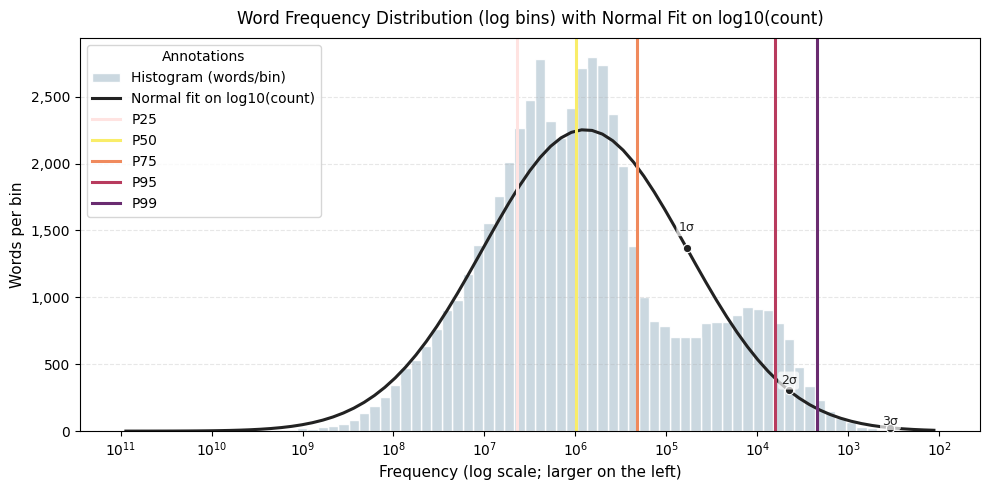

In [5]:
# -*- coding: utf-8 -*-
# Long-tail histogram of word frequencies with LOG-spaced bins (left=large, right=small).
# Adds a fitted Normal curve on log10(count) and marks the RIGHT-SIDE (small-count side)
# 1σ / 2σ / 3σ points with dots. (Because X is inverted, these are mu-σ, mu-2σ, mu-3σ.)
#
# - Y axis: number of words per bin (not density).
# - Percentile lines are UPPER-TAIL: P(count >= t) = p%.
# - Axis ticks/labels in English.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ---------- Config ----------
csv_path = "/Users/zhzhou/Desktop/SafeContextualReward/results/word_synthesis/v4_rpj_llama_s4/union_all_words_wf50000.csv"
n_bins   = 80
figsize  = (10, 5)

# Bars
bar_color = "#C9D6DF"   # softened cool gray-blue
alpha_bar = 0.95
edgecolor = "#FFFFFF"

# Percentile lines (upper-tail)
line_width = 2.2
tail_percents = [25, 50, 75, 95, 99]
line_colors = {
    25: "#FFE3E1",
    50: "#F9ED69",
    75: "#F08A5D",
    95: "#B83B5E",
    99: "#6A2C70",
}

# Normal-fit overlay (on log10 counts)
curve_color = "#222222"   # dark gray/black for the fit curve
curve_width = 2.2
sigma_marker_size = 36
sigma_marker_style = "o"
sigma_marker_edge = "white"
sigma_marker_edgewidth = 0.8

save_path = None  # e.g., "/tmp/long_tail_hist.png"
dpi = 180
# ----------------------------

assert os.path.exists(csv_path), f"CSV not found: {csv_path}"

# Read counts
df = pd.read_csv(csv_path, usecols=["count"], dtype={"count": "int64"})
counts = df["count"].to_numpy()
counts = counts[counts > 0]
if counts.size == 0:
    raise ValueError("No positive counts to plot.")

N = counts.size

# Upper-tail percentile thresholds: P(count >= t) = p%
pct_query = [100 - p for p in tail_percents]  # convert to ascending-space percentiles
tail_thresh = np.percentile(counts, pct_query)

# Log-spaced bin edges (uniform in log10 space)
min_c = max(int(counts.min()), 1)
max_c = int(counts.max())
edges = np.logspace(np.floor(np.log10(min_c)), np.ceil(np.log10(max_c)), num=n_bins)

# ----- Plot -----
fig, ax = plt.subplots(figsize=figsize)

# Histogram: words per bin
hist_vals, hist_edges, _ = ax.hist(
    counts,
    bins=edges,
    histtype="bar",
    color=bar_color,
    alpha=alpha_bar,
    edgecolor=edgecolor,
    label="Histogram (words/bin)",
)

# X axis log-scale, invert so larger counts on the left
ax.set_xscale("log")
ax.invert_xaxis()

# X ticks as descending powers of 10
exp_min = int(np.floor(np.log10(min_c)))
exp_max = int(np.ceil(np.log10(max_c)))
xticks = (10.0 ** np.arange(exp_max, exp_min - 1, -1)).astype(float)
ax.set_xticks(xticks)
ax.get_xaxis().set_major_formatter(mticker.LogFormatterMathtext(base=10))

# Y ticks with thousands separators
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{int(y):,}"))

# Grid
ax.grid(axis="y", linestyle="--", alpha=0.3)

# Labels & title
ax.set_xlabel("Frequency (log scale; larger on the left)", fontsize=11)
ax.set_ylabel("Words per bin", fontsize=11)
ax.set_title("Word Frequency Distribution (log bins) with Normal Fit on log10(count)", fontsize=12, pad=10)

# ---- Normal fit on log10(count) ----
xlog = np.log10(counts.astype(float))
mu = xlog.mean()
sigma = xlog.std(ddof=1)

# Compute expected counts per bin from Normal(mu, sigma^2) in log10-space.
edges_log = np.log10(hist_edges)
centers_log = 0.5 * (edges_log[:-1] + edges_log[1:])
delta_log = edges_log[1] - edges_log[0]  # constant bin width in log10 space

# Normal PDF in log10 space
norm_pdf = (1.0 / (sigma * np.sqrt(2.0 * np.pi))) * np.exp(-0.5 * ((centers_log - mu) / sigma) ** 2)

# Expected counts in each bin: N * PDF * bin_width_in_log_space
expected_counts = N * norm_pdf * delta_log

# Plot the smooth fitted curve (interpolate between centers)
x_fit_counts = 10 ** centers_log
ax.plot(x_fit_counts, expected_counts, color=curve_color, linewidth=curve_width, label="Normal fit on log10(count)")

# Mark the RIGHT-side (small-count side) ±σ points: these are mu-σ, mu-2σ, mu-3σ in log10 space
sigma_levels = [1, 2, 3]
right_log_points = [mu - k * sigma for k in sigma_levels]
right_counts = [10 ** z for z in right_log_points]

# Evaluate the expected-count curve at those points (using the same formula)
def expected_bin_count_at_logz(logz):
    pdf = (1.0 / (sigma * np.sqrt(2.0 * np.pi))) * np.exp(-0.5 * ((logz - mu) / sigma) ** 2)
    return N * pdf * delta_log

right_expected_counts = [expected_bin_count_at_logz(z) for z in right_log_points]

ax.scatter(
    right_counts,
    right_expected_counts,
    s=sigma_marker_size,
    marker=sigma_marker_style,
    color=curve_color,
    edgecolor=sigma_marker_edge,
    linewidth=sigma_marker_edgewidth,
    zorder=5,
)

# Annotate the three points as "1σ", "2σ", "3σ"
ymax = ax.get_ylim()[1]
for k, xc, yc in zip(sigma_levels, right_counts, right_expected_counts):
    ax.text(
        xc,
        min(yc * 1.08, ymax * 0.96),
        f"{k}σ",
        rotation=0,
        va="bottom",
        ha="center",
        fontsize=9,
        color=curve_color,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7),
        zorder=6,
    )

# Percentile lines (upper-tail)
for p, t in zip(tail_percents, tail_thresh):
    color = line_colors[p]
    ax.axvline(t, color=color, linestyle="-", linewidth=line_width, alpha=1.0, label=f"P{p}")

# Legend
ax.legend(frameon=True, loc="upper left", title="Annotations")

plt.tight_layout()
if save_path:
    plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
# plt.show()

# Optional: print summary
print(f"Normal fit on log10(count): mu={mu:.4f}, sigma={sigma:.4f}")
for p, t in zip(tail_percents, tail_thresh):
    print(f"Upper-tail P{p}: threshold t = {int(t):,}")
for k, xc in zip(sigma_levels, right_counts):
    print(f"Right-side {k}σ position (count scale): {xc:.3e}")
